In [13]:
import pandas as pd
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


In [14]:
data = pd.read_csv("data/LengthOfStay.csv")
#Removing vdate and dischared variables as they are not need for the model
columns_to_remove = ['vdate','discharged','secondarydiagnosisnonicd9', 'facid']
data = data.drop(columns = columns_to_remove)
#data = data.drop(columns = 'rcount')

# add 'rcount', 'eid' to columns_to_remove

In [15]:
# Identifying missing values if any
missing_values = data.isna().sum()
#missing_values

In [16]:
data.head()

,eid,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,...,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,lengthofstay
0,1,0,F,0,0,0,0,0,0,0,...,11.5,14.20,140.361132,192.476918,12.0,1.390722,30.432418,96,6.5,3
1,2,5+,F,0,0,0,0,0,0,0,...,9.0,4.10,136.731692,94.078507,8.0,0.943164,28.460516,61,6.5,7
2,3,1,F,0,0,0,0,0,0,0,...,8.4,8.90,133.058514,130.530524,12.0,1.065750,28.843812,64,6.5,3
3,4,0,F,0,0,0,0,0,0,0,...,11.9,9.40,138.994023,163.377028,12.0,0.906862,27.959007,76,6.5,1
4,5,0,F,0,0,0,1,0,1,0,...,9.1,9.05,138.634836,94.886654,11.5,1.242854,30.258927,67,5.6,4


Feature Engineering 
## Feature Engineering:
## 1- Standardization: hematocrit, neutrophils, sodium, glucose, bloodureanitro, creatinine, bmi, pulse, respiration.
## 2- Number of preidentified medical conditions: number_of_issues.



In [17]:
from sklearn.preprocessing import OneHotEncoder
# Create an instance of OneHotEncoder
encoder = OneHotEncoder()

# Assuming 'data' is your DataFrame and 'gender' is the column you want to one-hot encode
gender_encoded = encoder.fit_transform(data[['gender']])

# Convert the result to a DataFrame and specify column names
gender_encoded_df = pd.DataFrame(gender_encoded.toarray(), columns=encoder.get_feature_names_out(['gender']))

# Make sure the indices match
gender_encoded_df.index = data.index

# Concatenate the one-hot encoded DataFrame with the original DataFrame
data = pd.concat([data, gender_encoded_df], axis=1)

# Drop the original 'gender' column 
data.drop(columns=['gender'], inplace=True)

# Drop the original 'gender' column 
#data.drop(columns=['gender'], inplace=True)

In [18]:
data.head()

,eid,rcount,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,...,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,lengthofstay,gender_F,gender_M
0,1,0,0,0,0,0,0,0,0,0,...,140.361132,192.476918,12.0,1.390722,30.432418,96,6.5,3,1.0,0.0
1,2,5+,0,0,0,0,0,0,0,0,...,136.731692,94.078507,8.0,0.943164,28.460516,61,6.5,7,1.0,0.0
2,3,1,0,0,0,0,0,0,0,0,...,133.058514,130.530524,12.0,1.065750,28.843812,64,6.5,3,1.0,0.0
3,4,0,0,0,0,0,0,0,0,0,...,138.994023,163.377028,12.0,0.906862,27.959007,76,6.5,1,1.0,0.0
4,5,0,0,0,0,1,0,1,0,0,...,138.634836,94.886654,11.5,1.242854,30.258927,67,5.6,4,1.0,0.0


In [19]:
from sklearn.preprocessing import StandardScaler
# Standardize the specified columns
scaler = StandardScaler()
columns_to_standardize = ['hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration']
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])


In [20]:
#Creating a variables that represents the number of issues a patient had. 
# This helps reduce the dimensions for our model

data["number_of_issues"] = data[['hemo', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence',
                                  'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother', 'malnutrition']].sum(axis=1)

#sums up the values in the specified columns and assigns the result to 'number_of_issues'


In [21]:
data['stay_long'] = (data['lengthofstay'] >= 7).astype(float)

In [22]:
columns_to_drop = ['hemo', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence',
                                  'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother', 'malnutrition','rcount','eid']
data1 = data.drop(columns=columns_to_drop)

In [23]:
data1.head()

,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,lengthofstay,gender_F,gender_M,number_of_issues,stay_long
0,-0.234247,0.751441,0.823340,1.684186,-0.161915,1.454965,0.312741,1.936991,0.010963,3,1.0,0.0,0,0.0
1,-1.464694,-1.135314,-0.386613,-1.596543,-0.470738,-0.779911,-0.671360,-1.068721,0.010963,7,1.0,0.0,0,1.0
2,-1.760001,-0.238638,-1.611147,-0.381186,-0.161915,-0.167779,-0.480071,-0.811089,0.010963,3,1.0,0.0,0,0.0
3,-0.037375,-0.145235,0.367584,0.713958,-0.161915,-0.961187,-0.921644,0.219441,0.010963,1,1.0,0.0,0,0.0
4,-1.415476,-0.210617,0.247842,-1.569599,-0.200518,0.716587,0.226159,-0.553456,-1.572234,4,1.0,0.0,2,0.0


In [24]:
data1.dtypes
data=data1

In [25]:
# Splitting the data in to our predictor variables and target variable (Length of stay greater than 7 days)
predictor_variables = ['hematocrit', 'neutrophils', 'sodium','glucose',
                      'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration','gender_F' ,'gender_M','number_of_issues']
X = data1[predictor_variables]
Y = data1['stay_long']

## Splitting data into training and testing set

In [26]:
from sklearn.model_selection import train_test_split 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Model Training and Evaluation

## Random Forest

In [27]:
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
# Create RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_classifier, param_distributions=param_grid, n_iter=100, 
    scoring='accuracy', cv=5, verbose=2, random_state=42, n_jobs=-1
)
# Perform the random search
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Parameters:", random_search.best_params_)

# Print the best cross-validation score
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\topsn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
Best Score: 0.8529875


Feature ranking:


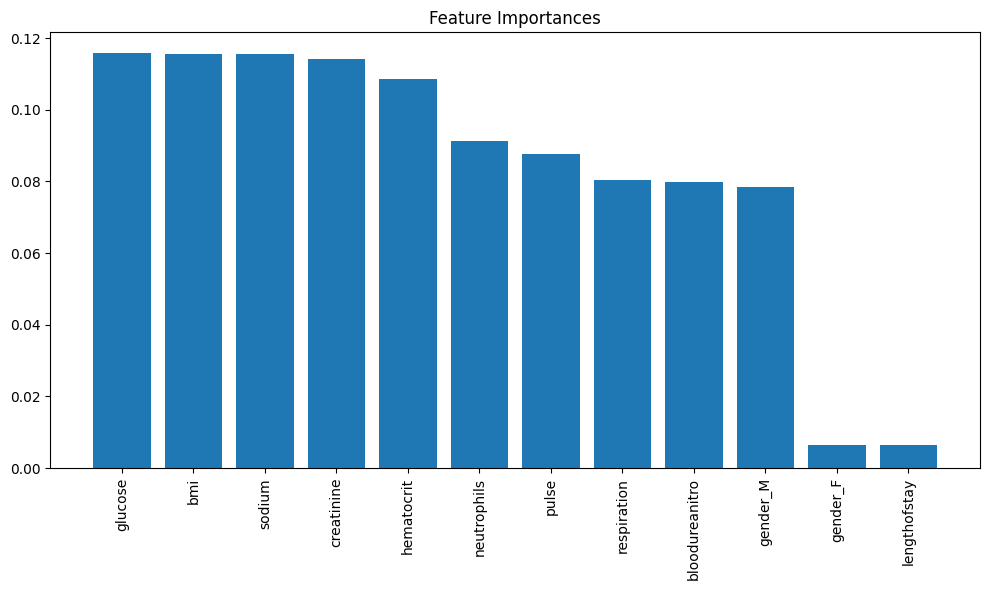

In [28]:
# Get the best model from the random search
best_rf_regressor = random_search.best_estimator_
# Get feature importances of the best model
feature_importances = best_rf_regressor.feature_importances_

# Get the names of the features
feature_names = data.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking
print("Feature ranking:")



# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

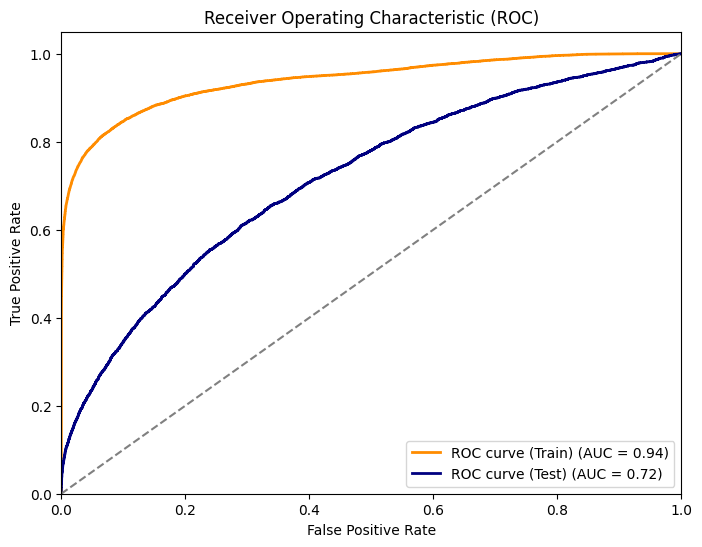

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Use the best_estimator obtained from RandomizedSearchCV
classifier = random_search.best_estimator_

# Predict probabilities for the positive class (class 1) for both training and testing data
y_train_prob = classifier.predict_proba(X_train)[:, 1]
y_test_prob = classifier.predict_proba(X_test)[:, 1]


# Compute ROC curve and AUC for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for testing data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves for training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (Train) (AUC = {:.2f})'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label='ROC curve (Test) (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# GBM

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the hyperparameter search space
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
}


#Create a GradientBoostingRegressor instance
gb_regressor = GradientBoostingClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    gb_regressor,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,        # 5-fold cross-validation
    n_jobs=-1,   # Use all available CPU cores
    verbose=1,
    random_state=42
)

# Perform the random search
random_search.fit(X_test, y_test)

# Print the best hyperparameters
print("Best Parameters:", random_search.best_params_)

# Print the best cross-validation score
print("Best Score:", random_search.best_score_)




Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 177, 'subsample': 0.7}
Best Score: 0.8542500000000001


Feature ranking:


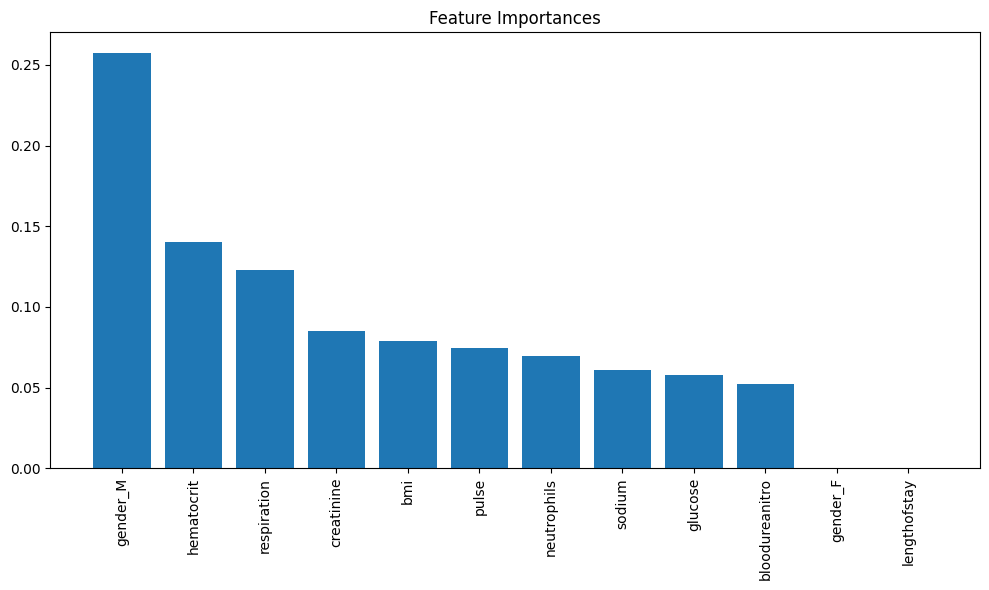

In [31]:
# Get the best model from the random search
best_gb = random_search.best_estimator_
# Get feature importances of the best model
feature_importances = best_gb.feature_importances_

# Get the names of the features
feature_names = data.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking
print("Feature ranking:")



# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

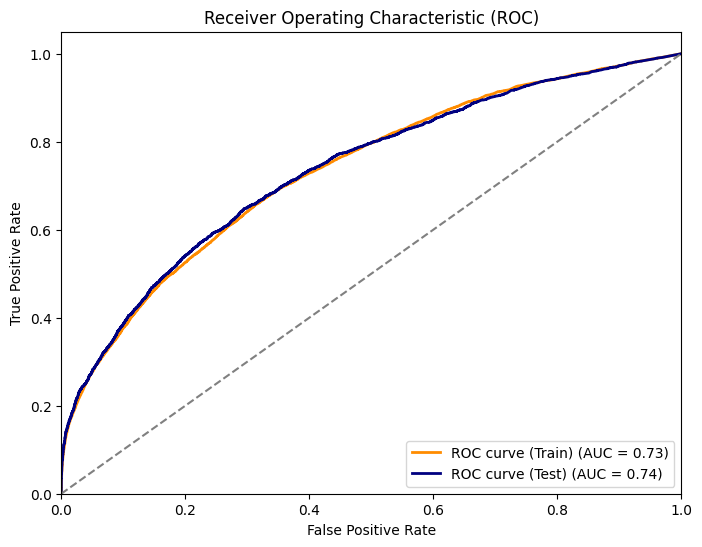

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Use the best_estimator obtained from RandomizedSearchCV
classifier = random_search.best_estimator_

# Predict probabilities for the positive class (class 1) for both training and testing data
y_train_prob = classifier.predict_proba(X_train)[:, 1]
y_test_prob = classifier.predict_proba(X_test)[:, 1]


# Compute ROC curve and AUC for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for testing data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves for training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (Train) (AUC = {:.2f})'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label='ROC curve (Test) (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Logistic regression

In [33]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression classifier
logistic_regression = LogisticRegression()

# Define hyperparameter grid for random search
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 100),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': np.arange(100, 1000, 100),
    'multi_class': ['auto', 'ovr', 'multinomial']
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=logistic_regression,
    param_distributions=param_grid,
    n_iter=100,  # Number of random parameter combinations to try
    scoring='accuracy',
    cv=5,  # Number of cross-validation folds
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Accuracy: {:.2f}%".format(random_search.best_score_ * 100))

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

c:\Users\topsn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
295 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\topsn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\topsn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best Hyperparameters:  {'solver': 'saga', 'penalty': 'l1', 'multi_class': 'auto', 'max_iter': 900, 'C': 0.0041320124001153384}
Best Accuracy: 84.30%
Test Accuracy: 84.19%


# SVM

In [35]:
from sklearn.svm import SVC
from scipy.stats import uniform

# Define the SVM classifier
svm_classifier = SVC()

# Define a parameter grid for hyperparameter tuning
param_dist = {
    'C': uniform(loc=0, scale=10),  # Regularization parameter C
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))  # Kernel coefficient for 'rbf' and 'poly'
}

# Create a random search cross-validation object
random_search = RandomizedSearchCV(
    svm_classifier,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Increase for more details
    n_jobs=-1  # Use all available CPU cores for parallel processing
)

# Perform the random search to find the best hyperparameters
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the classifier with the best hyperparameters on the test set
best_svm_classifier = random_search.best_estimator_
accuracy = best_svm_classifier.score(X_test, y_test)
print("Accuracy on Test Set:", accuracy)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


# CatBoost